# Chapter 8: ニューラルネット

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

## 70. 単語ベクトルの和による特徴量

問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例$x_i$の特徴ベクトル$\boldsymbol{x}_i$を並べた行列$X$と，正解ラベルを並べた行列（ベクトル）$Y$を作成したい．

$$
X = \begin{pmatrix} 
  \boldsymbol{x}_1 \\ 
  \boldsymbol{x}_2 \\ 
  \dots \\ 
  \boldsymbol{x}_n \\ 
\end{pmatrix} \in \mathbb{R}^{n \times d},
Y = \begin{pmatrix} 
  y_1 \\ 
  y_2 \\ 
  \dots \\ 
  y_n \\ 
\end{pmatrix} \in \mathbb{N}^{n}
$$

ここで，$n$は学習データの事例数であり，$\boldsymbol{x}_i \in \mathbb{R}^d$と$y_i \in \mathbb{N}$はそれぞれ，$i \in \{1, \dots, n\}$番目の事例の特徴量ベクトルと正解ラベルを表す．
なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．$\mathbb{N}_{<4}$で$4$未満の自然数（$0$を含む）を表すことにすれば，任意の事例の正解ラベル$y_i$は$y_i \in \mathbb{N}_{<4}$で表現できる．
以降では，ラベルの種類数を$L$で表す（今回の分類タスクでは$L=4$である）．

$i$番目の事例の特徴ベクトル$\boldsymbol{x}_i$は，次式で求める．

$$
\boldsymbol{x}_i = \frac{1}{T_i} \sum_{t=1}^{T_i} \mathrm{emb}(w_{i,t})
$$

ここで，$i$番目の事例は$T_i$個の（記事見出しの）単語列$(w_{i,1}, w_{i,2}, \dots, w_{i,T_i})$から構成され，$\mathrm{emb}(w) \in \mathbb{R}^d$は単語$w$に対応する単語ベクトル（次元数は$d$）である．すなわち，$i$番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものが$\boldsymbol{x}_i$である．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．$300$次元の単語ベクトルを用いたので，$d=300$である．

$i$番目の事例のラベル$y_i$は，次のように定義する．

$$
y_i = \begin{cases}
0 & (\mbox{記事}x_i\mbox{が「ビジネス」カテゴリの場合}) \\
1 & (\mbox{記事}x_i\mbox{が「科学技術」カテゴリの場合}) \\
2 & (\mbox{記事}x_i\mbox{が「エンターテイメント」カテゴリの場合}) \\
3 & (\mbox{記事}x_i\mbox{が「健康」カテゴリの場合}) \\
\end{cases}
$$

なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

+ 学習データの特徴量行列: $X_{\rm train} \in \mathbb{R}^{N_t \times d}$
+ 学習データのラベルベクトル: $Y_{\rm train} \in \mathbb{N}^{N_t}$
+ 検証データの特徴量行列: $X_{\rm valid} \in \mathbb{R}^{N_v \times d}$
+ 検証データのラベルベクトル: $Y_{\rm valid} \in \mathbb{N}^{N_v}$
+ 評価データの特徴量行列: $X_{\rm test} \in \mathbb{R}^{N_e \times d}$
+ 評価データのラベルベクトル: $Y_{\rm test} \in \mathbb{N}^{N_e}$

なお，$N_t, N_v, N_e$はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [10]:
import pandas as pd
import numpy as np

In [4]:
train_df = pd.read_table('../data/news_aggregator/train.txt')
valid_df = pd.read_table('../data/news_aggregator/valid.txt')
test_df = pd.read_table('../data/news_aggregator/test.txt')

In [6]:
categories = ['b', 't', 'e', 'm']

In [7]:
from gensim.models import KeyedVectors

In [8]:
model = KeyedVectors.load_word2vec_format('../data/google_news.bin.gz', binary=True)

In [115]:
# tokenize, make lowercase and make stem

import re
import string

def tokenize(x):
    table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    x = x.translate(table).split()
    x = [w.lower() for w in x]
    return x

In [116]:
train_df['tokens'] = train_df['title'].map(tokenize)
valid_df['tokens'] = valid_df['title'].map(tokenize)
test_df['tokens'] = test_df['title'].map(tokenize)

In [117]:
def labelize(x):
    return categories.index(x)

In [118]:
train_df['label'] = train_df['category'].map(labelize)
valid_df['label'] = valid_df['category'].map(labelize)
test_df['label'] = test_df['category'].map(labelize)

In [2]:
import torch

def vectorize(tokens):
    vec = np.array([model[w] for w in tokens if w in model])
    return torch.tensor(np.mean(vec, axis=0))

In [125]:
X_train = torch.stack([vectorize(tokens) for tokens in train_df['tokens']])
X_valid = torch.stack([vectorize(tokens) for tokens in valid_df['tokens']])
X_test = torch.stack([vectorize(tokens) for tokens in test_df['tokens']])

In [122]:
y_train = torch.tensor(train_df['label'])
y_valid = torch.tensor(valid_df['label'])
y_test = torch.tensor(test_df['label'])

In [129]:
torch.save(X_train, '../data/X_train.pt')
torch.save(X_valid, '../data/X_valid.pt')
torch.save(X_test, '../data/X_test.pt')
torch.save(y_train, '../data/y_train.pt')
torch.save(y_valid, '../data/y_valid.pt')
torch.save(y_test, '../data/y_test.pt')

## 71. 単層ニューラルネットワークによる予測

問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

$$
\hat{\boldsymbol{y}}_1 = {\rm softmax}(\boldsymbol{x}_1 W), \\
\hat{Y} = {\rm softmax}(X_{[1:4]} W)
$$

ただし，${\rm softmax}$はソフトマックス関数，$X_{[1:4]} \in \mathbb{R}^{4 \times d}$は特徴ベクトル$\boldsymbol{x}_1, \boldsymbol{x}_2, \boldsymbol{x}_3, \boldsymbol{x}_4$を縦に並べた行列である．

$$
X_{[1:4]} = \begin{pmatrix} 
  \boldsymbol{x}_1 \\ 
  \boldsymbol{x}_2 \\ 
  \boldsymbol{x}_3 \\ 
  \boldsymbol{x}_4 \\ 
\end{pmatrix}
$$

行列$W \in \mathbb{R}^{d \times L}$は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，$\hat{\boldsymbol{y}}_1 \in \mathbb{R}^L$は未学習の行列$W$で事例$x_1$を分類したときに，各カテゴリに属する確率を表すベクトルである．
同様に，$\hat{Y} \in \mathbb{R}^{n \times L}$は，学習データの事例$x_1, x_2, x_3, x_4$について，各カテゴリに属する確率を行列として表現している．

In [3]:
X_train = torch.load('../data/X_train.pt')
X_valid = torch.load('../data/X_valid.pt')
X_test = torch.load('../data/X_test.pt')
y_train = torch.load('../data/y_train.pt')
y_valid = torch.load('../data/y_valid.pt')
y_test = torch.load('../data/y_test.pt')

In [4]:
from torch import nn

class SLPNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0)
    
    def forward(self, x):
        x = self.fc(x)
        return x

In [5]:
model = SLPNet(300, 4)
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
y_hat_1

tensor([[0.2459, 0.0837, 0.0331, 0.6374]], grad_fn=<SoftmaxBackward>)

In [6]:
Y_hat = torch.softmax(model(X_train[:4]), dim=-1)
Y_hat

tensor([[0.2459, 0.0837, 0.0331, 0.6374],
        [0.1812, 0.3768, 0.0854, 0.3566],
        [0.1670, 0.7075, 0.0291, 0.0963],
        [0.0173, 0.8451, 0.0378, 0.0999]], grad_fn=<SoftmaxBackward>)

## 72. 損失と勾配の計算

学習データの事例$x_1$と事例集合$x_1, x_2, x_3, x_4$に対して，クロスエントロピー損失と，行列$W$に対する勾配を計算せよ．なお，ある事例$x_i$に対して損失は次式で計算される．

$$
l_i = - \log [\mbox{事例}x_i\mbox{が}y_i\mbox{に分類される確率}]
$$

ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [7]:
criterion = nn.CrossEntropyLoss()

In [8]:
loss_1 = criterion(model(X_train[:1]), y_train[:1])
model.zero_grad()
loss_1.backward()

print(f'損失: {loss_1}')
print(f'勾配: {model.fc.weight.grad}')

損失: 1.4029898643493652
勾配: tensor([[ 0.0230, -0.0311, -0.0346,  ..., -0.0311, -0.0035, -0.0360],
        [-0.0026,  0.0034,  0.0038,  ...,  0.0035,  0.0004,  0.0040],
        [-0.0010,  0.0014,  0.0015,  ...,  0.0014,  0.0002,  0.0016],
        [-0.0195,  0.0263,  0.0293,  ...,  0.0263,  0.0029,  0.0305]])


In [9]:
loss = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
loss.backward()

print(f'損失: {loss}')
print(f'勾配: {model.fc.weight.grad}')

損失: 2.676755905151367
勾配: tensor([[ 0.0123, -0.0212, -0.0280,  ..., -0.0171, -0.0167, -0.0125],
        [-0.0332,  0.0424,  0.0232,  ..., -0.0134, -0.0163,  0.0346],
        [ 0.0299, -0.0354, -0.0063,  ...,  0.0288,  0.0304, -0.0293],
        [-0.0091,  0.0141,  0.0111,  ...,  0.0017,  0.0027,  0.0072]])


## 73. 確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [10]:
from torch.utils.data import Dataset, DataLoader

In [11]:
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [12]:
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

In [13]:
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [64]:
model = SLPNet(300, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [16]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
    
    loss_train = loss_train / i
    
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)
        
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 1, loss_train: 0.5462, loss_valid: 0.4083
epoch: 2, loss_train: 0.3670, loss_valid: 0.3682
epoch: 3, loss_train: 0.3350, loss_valid: 0.3521
epoch: 4, loss_train: 0.3176, loss_valid: 0.3474
epoch: 5, loss_train: 0.3055, loss_valid: 0.3415
epoch: 6, loss_train: 0.2988, loss_valid: 0.3436
epoch: 7, loss_train: 0.2923, loss_valid: 0.3366
epoch: 8, loss_train: 0.2878, loss_valid: 0.3368
epoch: 9, loss_train: 0.2846, loss_valid: 0.3328
epoch: 10, loss_train: 0.2810, loss_valid: 0.3313
epoch: 11, loss_train: 0.2784, loss_valid: 0.3340
epoch: 12, loss_train: 0.2766, loss_valid: 0.3353
epoch: 13, loss_train: 0.2744, loss_valid: 0.3348
epoch: 14, loss_train: 0.2727, loss_valid: 0.3334
epoch: 15, loss_train: 0.2714, loss_valid: 0.3354
epoch: 16, loss_train: 0.2697, loss_valid: 0.3325
epoch: 17, loss_train: 0.2685, loss_valid: 0.3337
epoch: 18, loss_train: 0.2671, loss_valid: 0.3344
epoch: 19, loss_train: 0.2661, loss_valid: 0.3323
epoch: 20, loss_train: 0.2657, loss_valid: 0.3357
epoch: 21

## 74. 正解率の計測

問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [110]:
def calculate_accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

    return correct / total

In [18]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'train accuracy: {acc_train:.3f}')
print(f'test accuracy: {acc_test:.3f}')

train accuracy: 0.916
test accuracy: 0.895


## 75. 損失と正解率のプロット

問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [53]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

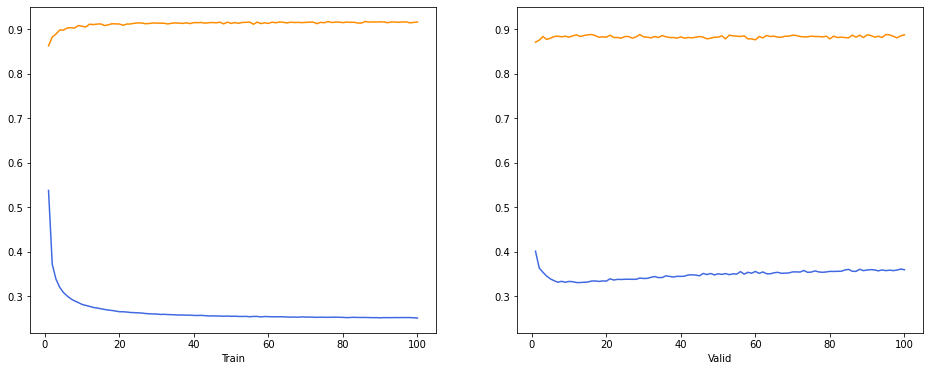

100%|██████████| 100/100 [07:40<00:00,  4.60s/it]


In [63]:
accuracy_res = {
    'train': [],
    'valid': []
}

loss_res = {
    'train': [],
    'valid': []
}

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
ax1.set_xlabel('Train')
ax2.set_xlabel('Valid')

num_epochs = 100

for epoch in tqdm(range(num_epochs)):
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
    
    loss_train = loss_train / i
    
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)
        
    train_accuracy = calculate_accuracy(model, dataloader_train)
    valid_accuracy = calculate_accuracy(model, dataloader_valid)

    accuracy_res['train'].append(train_accuracy)
    accuracy_res['valid'].append(valid_accuracy)

    loss_res['train'].append(loss_train)
    loss_res['valid'].append(loss_valid)

    
    clear_output(wait=True)
    
    line1, = ax1.plot(range(1, epoch + 2), loss_res['train'], label='loss', color='royalblue')
    line2, = ax1.plot(range(1, epoch + 2), accuracy_res['train'], label='train', color='darkorange')

    line3, = ax2.plot(range(1, epoch + 2), loss_res['valid'], label='loss', color='royalblue')
    line4, = ax2.plot(range(1, epoch + 2), accuracy_res['valid'], label='accuracy', color='darkorange')
    
    display(fig)
    
    line1.remove()
    line2.remove()
    line3.remove()
    line4.remove()
    
plt.close(fig)

## 76. チェックポイント

問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

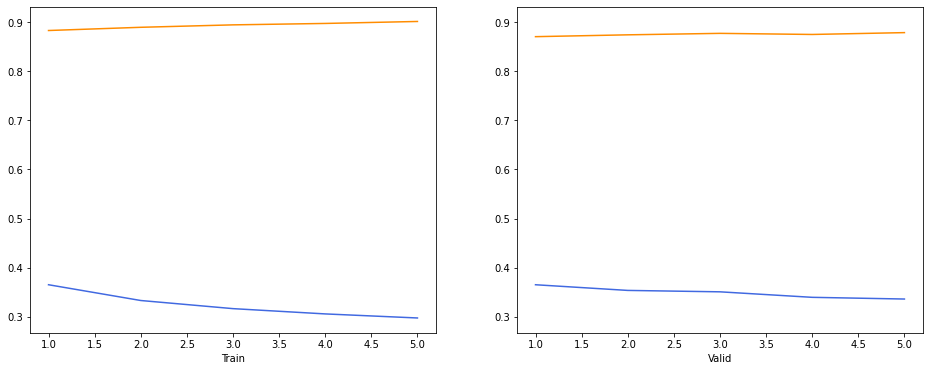

100%|██████████| 5/5 [00:23<00:00,  4.60s/it]


In [66]:
accuracy_res = {
    'train': [],
    'valid': []
}

loss_res = {
    'train': [],
    'valid': []
}

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
ax1.set_xlabel('Train')
ax2.set_xlabel('Valid')

num_epochs = 5

for epoch in tqdm(range(num_epochs)):
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
    
    loss_train = loss_train / i
    
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)
        
    train_accuracy = calculate_accuracy(model, dataloader_train)
    valid_accuracy = calculate_accuracy(model, dataloader_valid)

    accuracy_res['train'].append(train_accuracy)
    accuracy_res['valid'].append(valid_accuracy)

    loss_res['train'].append(loss_train)
    loss_res['valid'].append(loss_valid)

    
    clear_output(wait=True)
    
    line1, = ax1.plot(range(1, epoch + 2), loss_res['train'], label='loss', color='royalblue')
    line2, = ax1.plot(range(1, epoch + 2), accuracy_res['train'], label='train', color='darkorange')

    line3, = ax2.plot(range(1, epoch + 2), loss_res['valid'], label='loss', color='royalblue')
    line4, = ax2.plot(range(1, epoch + 2), accuracy_res['valid'], label='accuracy', color='darkorange')
    
    display(fig)
    
    line1.remove()
    line2.remove()
    line3.remove()
    line4.remove()
    
    torch.save({
        'epoch': 'epoch',
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, f'../data/checkpoints/checkpoint_{epoch}.pt')
    
plt.close(fig)

## 77. ミニバッチ化

問題76のコードを改変し，$B$事例ごとに損失・勾配を計算し，行列$W$の値を更新せよ（ミニバッチ化）．$B$の値を$1, 2, 4, 8, \dots$と変化させながら，1エポックの学習に要する時間を比較せよ．

In [79]:
import datetime

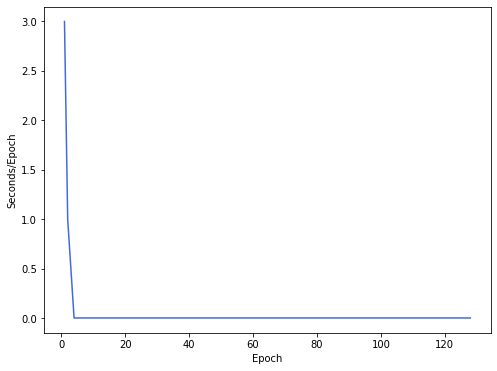

In [101]:
batch_sizes = [2 ** x for x in range(8)]
times = []

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Seconds/Epoch')

num_epochs = 5

for idx, batch_size in enumerate(batch_sizes):
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    
    model = SLPNet(300, 4)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
    
    start_time = datetime.datetime.now()
    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_train = 0.0
        for i, (inputs, labels) in enumerate(dataloader_train):
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_train = loss_train / i

        model.eval()
        with torch.no_grad():
            inputs, labels = next(iter(dataloader_valid))
            outputs = model(inputs)
            loss_valid = criterion(outputs, labels)

        
    
    end_time = datetime.datetime.now()
    average_time = (end_time - start_time) / num_epochs
    times.append(average_time.seconds)
    
    clear_output(wait=True)
    try:
        line.remove()
    except:
        pass

    line, = ax.plot(batch_sizes[:idx+1], times, color='royalblue')
    
    display(fig)
    
plt.close(fig)

## 78. GPU上での学習

問題77のコードを改変し，GPU上で学習を実行せよ．

In [112]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [122]:
dataloader_train = DataLoader(dataset_train, batch_size=5, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [123]:
model = SLPNet(300, 4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

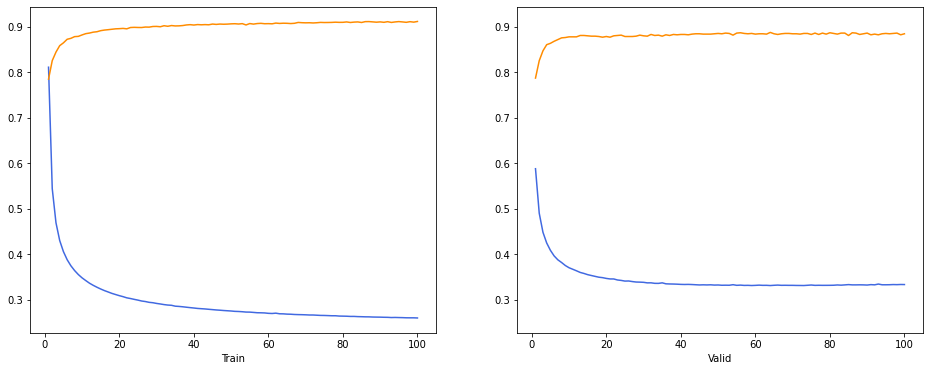

100%|██████████| 100/100 [05:51<00:00,  3.52s/it]


In [124]:
accuracy_res = {
    'train': [],
    'valid': []
}

loss_res = {
    'train': [],
    'valid': []
}

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
ax1.set_xlabel('Train')
ax2.set_xlabel('Valid')

num_epochs = 100

for epoch in tqdm(range(num_epochs)):
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
    
    loss_train = loss_train / i
    
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)
        
    train_accuracy = calculate_accuracy(model, dataloader_train)
    valid_accuracy = calculate_accuracy(model, dataloader_valid)

    accuracy_res['train'].append(train_accuracy)
    accuracy_res['valid'].append(valid_accuracy)

    loss_res['train'].append(loss_train)
    loss_res['valid'].append(loss_valid)

    
    clear_output(wait=True)
    
    line1, = ax1.plot(range(1, epoch + 2), loss_res['train'], label='loss', color='royalblue')
    line2, = ax1.plot(range(1, epoch + 2), accuracy_res['train'], label='train', color='darkorange')

    line3, = ax2.plot(range(1, epoch + 2), loss_res['valid'], label='loss', color='royalblue')
    line4, = ax2.plot(range(1, epoch + 2), accuracy_res['valid'], label='accuracy', color='darkorange')
    
    display(fig)
    
    line1.remove()
    line2.remove()
    line3.remove()
    line4.remove()
    
plt.close(fig)

## 79. 多層ニューラルネットワーク

問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [141]:
from torch import nn

class MLPNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512, bias=True)
        self.fc2 = nn.Linear(512, 128, bias=True)
        self.fc3 = nn.Linear(128, output_size, bias=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [142]:
dataloader_train = DataLoader(dataset_train, batch_size=20, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [143]:
model = MLPNet(300, 4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

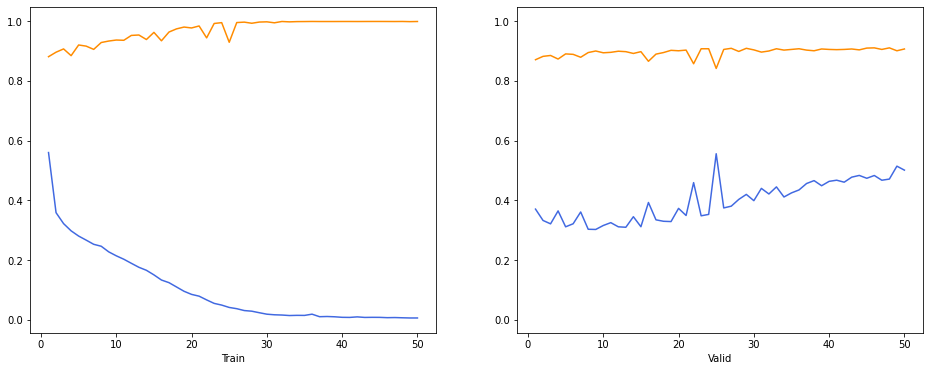

100%|██████████| 50/50 [01:43<00:00,  2.08s/it]


In [144]:
accuracy_res = {
    'train': [],
    'valid': []
}

loss_res = {
    'train': [],
    'valid': []
}

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
ax1.set_xlabel('Train')
ax2.set_xlabel('Valid')

num_epochs = 50

for epoch in tqdm(range(num_epochs)):
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
    
    loss_train = loss_train / i
    
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)
        
    train_accuracy = calculate_accuracy(model, dataloader_train)
    valid_accuracy = calculate_accuracy(model, dataloader_valid)

    accuracy_res['train'].append(train_accuracy)
    accuracy_res['valid'].append(valid_accuracy)

    loss_res['train'].append(loss_train)
    loss_res['valid'].append(loss_valid)

    
    clear_output(wait=True)
    
    line1, = ax1.plot(range(1, epoch + 2), loss_res['train'], label='loss', color='royalblue')
    line2, = ax1.plot(range(1, epoch + 2), accuracy_res['train'], label='train', color='darkorange')

    line3, = ax2.plot(range(1, epoch + 2), loss_res['valid'], label='loss', color='royalblue')
    line4, = ax2.plot(range(1, epoch + 2), accuracy_res['valid'], label='accuracy', color='darkorange')
    
    display(fig)
    
    line1.remove()
    line2.remove()
    line3.remove()
    line4.remove()
    
plt.close(fig)

In [145]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'train accuracy: {acc_train:.3f}')
print(f'test accuracy: {acc_test:.3f}')

train accuracy: 0.999
test accuracy: 0.910
